In [1]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from scipy.signal import butter, filtfilt
from sklearn.metrics import roc_curve
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams

import h5py, numpy as np
import os

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [ ]:
fig_dir = "./figures"
data_dir = "./data"
results_dir = "./results"

os.makedirs(fig_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

### EDAD algorithm definition

In [3]:
class EDAD():

    def __init__(self, lr, mom_score, mode, n_learning, device='cpu'):
        self.lr = lr
        self.mom_score = mom_score
        self.mode = mode
        self.n_learning = n_learning
        self.device = device

    def fit(self, X, y=None):

        device = self.device

        X = torch.tensor(X, dtype=torch.float).to(device)
        R = torch.eye(X.shape[1], dtype=torch.float).to(device)
        self.p = (1.0) / (X.shape[1] - 1)

        # ---------------------------------------------------------
        #  MODE: UNSUPERVISED ('u')
        # ---------------------------------------------------------
        if self.mode == 'u':

            NR = torch.zeros(X.shape[0]).to(device)

            for i in tqdm(range(X.shape[0]), desc="EDAD (unsupervised)"):
                XD = F.linear(X[i:i+1, :], R)
                XD = (XD.T @ XD) / len(XD)
                XD -= torch.diag(torch.diag(XD))
                XD = (self.p * XD @ R)
                XD = self.lr * XD
                R -= XD
                NR[i] = torch.norm(R)

            NR = np.abs(np.gradient(NR.cpu()))
            scores = np.zeros(len(NR))
            scores[0] = NR[0]

            for i in range(len(NR)):
                scores[i] = (1 - self.mom_score) * scores[i - 1] + self.mom_score * NR[i]

            decision_scores = torch.nan_to_num(torch.tensor(scores), nan=0.0, posinf=0.0, neginf=0.0)

            self.decision_scores_ = decision_scores

        # ---------------------------------------------------------
        #  MODE: SEMI-SUPERVISED ('s')
        # ---------------------------------------------------------
        elif self.mode == 's':

            NR = torch.zeros(X.shape[0] - self.n_learning).to(device)

            for i in tqdm(range(X.shape[0]), desc="EDAD (semi-supervised)"):
                XD = F.linear(X[i:i+1, :], R)
                XD = (XD.T @ XD) / len(XD)
                XD -= torch.diag(torch.diag(XD))
                XD = (self.p * XD @ R)

                if i > self.n_learning - 1:
                    NR[i - self.n_learning] = torch.mean(XD)
                else:
                    R -= (self.lr * XD)
                    if i == self.n_learning - 1:
                        print("Stopping R updates at step", i)

            self.decision_scores_ = NR


### Loading LHC dataset

In [4]:
def load_events(path):
    with h5py.File(path, "r") as f:
        X = f["Particles"][...]
    return X


X_bg  = load_events(os.path.join(data_dir, "background_for_training.h5"))
X_bg = X_bg[:, :, :-1].reshape(X_bg.shape[0], -1)

X_sig1 = load_events(os.path.join(data_dir, "leptoquark_LOWMASS_lepFilter_13TeV.h5"))
X_sig1 = X_sig1[:, :, :-1].reshape(X_sig1.shape[0], -1)

X_sig2 = load_events(os.path.join(data_dir, "Ato4l_lepFilter_13TeV.h5"))
X_sig2 = X_sig2[:, :, :-1].reshape(X_sig2.shape[0], -1)

X_sig3 = load_events(os.path.join(data_dir, "hToTauTau_13TeV_PU20.h5")) 
X_sig3 = X_sig3[:, :, :-1].reshape(X_sig3.shape[0], -1)

X_sig4 = load_events(os.path.join(data_dir, "hChToTauNu_13TeV_PU20.h5"))
X_sig4 = X_sig4[:, :, :-1].reshape(X_sig4.shape[0], -1)



print("Background shape: ", X_bg.shape)
print("Signal1 shape: ", X_sig1.shape)
print("Signal2 shape: ", X_sig2.shape)
print("Signal3 shape: ", X_sig3.shape)
print("Signal4 shape: ", X_sig4.shape)

Background shape:  (4000000, 57)
Signal1 shape:  (340544, 57)
Signal2 shape:  (55969, 57)
Signal3 shape:  (691283, 57)
Signal4 shape:  (760272, 57)


In [5]:
train_length = 80000

# X_bg_train, X_bg_test = train_test_split(
#     X_bg, 
#     train_size=train_length, 
#     # test_size=80000, 
#     shuffle=True, 
#     random_state=None
# )

In [6]:
# save train and test splits
# np.save(os.path.join(data_dir,"LHC_L1T_X_bg_train.npy"), X_bg_train)
# np.save(os.path.join(data_dir,"LHC_L1T_X_bg_test.npy"), X_bg_test)

# load train and test splits
X_bg_train = np.load(os.path.join(data_dir,"LHC_L1T_X_bg_train.npy"))
X_bg_test = np.load(os.path.join(data_dir,"LHC_L1T_X_bg_test.npy"))

In [20]:
learning_rate = 8e-7
result_dir_lr = os.path.join(results_dir, f"{learning_rate}")
os.makedirs(result_dir_lr, exist_ok=True)

### Training + Test on Background

In [21]:
EDAD_model = EDAD(lr=learning_rate, mom_score=0.25, mode='s', n_learning=train_length, device="cpu")
EDAD_model.fit(np.concatenate([X_bg_train, X_bg_test]))
Score_BG_total = EDAD_model.decision_scores_

EDAD (semi-supervised):   2%|▏         | 82498/4000000 [00:03<03:00, 21745.14it/s]

Stopping R updates at step 79999


EDAD (semi-supervised): 100%|██████████| 4000000/4000000 [02:50<00:00, 23444.95it/s]


In [22]:
# save Score_BG_total
np.save(os.path.join(result_dir_lr,f"LHC_L1T_Score_BG_test_lr_{learning_rate}.npy"), Score_BG_total.cpu().numpy())
# Score_BG_total = np.load(os.path.join(results_dir,f"LHC_L1T_Score_BG_total_lr_{learning_rate}.npy"))

#### LQ → bτ

In [23]:
EDAD_model = EDAD(lr=learning_rate, mom_score=0.25, mode='s', n_learning=train_length, device="cpu")
EDAD_model.fit(np.concatenate([X_bg_train, X_sig1]))
Score_LQ = EDAD_model.decision_scores_

conc_score_bg_LQ = np.concatenate([Score_BG_total, Score_LQ])
labels_bg_LQ = np.concatenate([np.zeros(len(Score_BG_total)), np.ones(len(Score_LQ))])
AUC_LQ = roc_auc_score(labels_bg_LQ, conc_score_bg_LQ)
print("LQ, ROC/AUC (EDAD): ", AUC_LQ)

EDAD (semi-supervised):  20%|██        | 84127/420544 [00:04<00:15, 21851.80it/s]

Stopping R updates at step 79999


EDAD (semi-supervised): 100%|██████████| 420544/420544 [00:18<00:00, 22765.19it/s]


LQ, ROC/AUC (EDAD):  0.8985674752171735


In [24]:
np.save(os.path.join(result_dir_lr,f"LHC_L1T_Score_LQ_lr_{learning_rate}.npy"), Score_LQ.cpu().numpy())

#### A → 4l

In [25]:
EDAD_model = EDAD(lr=learning_rate, mom_score=0.25, mode='s', n_learning=train_length, device="cpu")
EDAD_model.fit(np.concatenate([X_bg_train, X_sig2]))
Score_A = EDAD_model.decision_scores_

conc_score_bg_A = np.concatenate([Score_BG_total, Score_A])
labels_bg_A = np.concatenate([np.zeros(len(Score_BG_total)), np.ones(len(Score_A))])
AUC_A = roc_auc_score(labels_bg_A, conc_score_bg_A)
print("A, ROC/AUC (EDAD): ", AUC_A)

EDAD (semi-supervised):   0%|          | 0/135969 [00:00<?, ?it/s]

EDAD (semi-supervised):  61%|██████    | 82949/135969 [00:04<00:02, 21628.03it/s]

Stopping R updates at step 79999


EDAD (semi-supervised): 100%|██████████| 135969/135969 [00:06<00:00, 21679.47it/s]


A, ROC/AUC (EDAD):  0.9261858280421995


In [26]:
np.save(os.path.join(result_dir_lr,f"LHC_L1T_Score_A_lr_{learning_rate}.npy"), Score_A.cpu().numpy())

#### h0 → ττ

In [27]:
EDAD_model = EDAD(lr=learning_rate, mom_score=0.25, mode='s', n_learning=train_length, device="cpu")
EDAD_model.fit(np.concatenate([X_bg_train, X_sig3]))
Score_h0 = EDAD_model.decision_scores_

conc_score_bg_h0 = np.concatenate([Score_BG_total, Score_h0])
labels_bg_h0 = np.concatenate([np.zeros(len(Score_BG_total)), np.ones(len(Score_h0))])
AUC_h0 = roc_auc_score(labels_bg_h0, conc_score_bg_h0)
print("h0, ROC/AUC (EDAD): ", AUC_h0)

EDAD (semi-supervised):  11%|█         | 82349/771283 [00:03<00:31, 21701.47it/s]

Stopping R updates at step 79999


EDAD (semi-supervised): 100%|██████████| 771283/771283 [00:33<00:00, 23059.16it/s]


h0, ROC/AUC (EDAD):  0.7682944312506451


In [28]:
np.save(os.path.join(result_dir_lr,f"LHC_L1T_Score_h0_lr_{learning_rate}.npy"), Score_h0.cpu().numpy())

#### h± → τν

In [29]:
EDAD_model = EDAD(lr=learning_rate, mom_score=0.25, mode='s', n_learning=train_length, device="cpu")
EDAD_model.fit(np.concatenate([X_bg_train, X_sig4]))
Score_hpn = EDAD_model.decision_scores_

conc_score_bg_hpn = np.concatenate([Score_BG_total, Score_hpn])
labels_bg_hpn = np.concatenate([np.zeros(len(Score_BG_total)), np.ones(len(Score_hpn))])
AUC_hpn = roc_auc_score(labels_bg_hpn, conc_score_bg_hpn)
print("hpn, ROC/AUC (EDAD): ", AUC_hpn)

EDAD (semi-supervised):  10%|▉         | 82686/840272 [00:03<00:34, 21863.73it/s]

Stopping R updates at step 79999


EDAD (semi-supervised): 100%|██████████| 840272/840272 [00:36<00:00, 23096.79it/s]


hpn, ROC/AUC (EDAD):  0.8147586960765965


In [30]:
np.save(os.path.join(result_dir_lr,f"LHC_L1T_Score_hpn_lr_{learning_rate}.npy"), Score_hpn.cpu().numpy())

In [31]:
fpr_1, tpr_1, thresholds_1 = roc_curve(labels_bg_LQ, conc_score_bg_LQ)
fpr_2, tpr_2, thresholds_2 = roc_curve(labels_bg_A, conc_score_bg_A)
fpr_3, tpr_3, thresholds_3 = roc_curve(labels_bg_h0, conc_score_bg_h0)
fpr_4, tpr_4, thresholds_4 = roc_curve(labels_bg_hpn, conc_score_bg_hpn)
# AUC
AUC1 = roc_auc_score(labels_bg_LQ, conc_score_bg_LQ)
AUC2 = roc_auc_score(labels_bg_A, conc_score_bg_A)
AUC3 = roc_auc_score(labels_bg_h0, conc_score_bg_h0)
AUC4 = roc_auc_score(labels_bg_hpn, conc_score_bg_hpn)

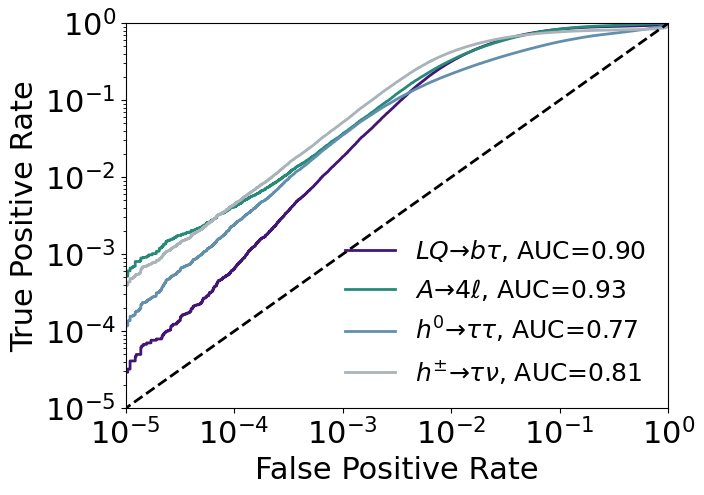

In [32]:
# -------- SETTINGS --------
# Custom color palette (tweak these HEX values to tune colors)
palette = [
    "#431676",  # blue
    "#268a79",  # orange
    "#618fac",  # red
    "#a9b3b9"  # green
]
# make legend markers larger
plt.rcParams['legend.markerscale'] = 2

# Font settings (Times New Roman or similar serif)
rcParams['font.family'] = ['sans-serif']
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['legend.fontsize'] = 18
rcParams['lines.linewidth'] = 2
rcParams['legend.frameon'] = False

# figure for all signals
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(fpr_1, tpr_1, label=f'${{LQ → bτ}}$, AUC={AUC1:.2f}', color=palette[0])
plt.plot(fpr_2, tpr_2, label=f'$A → 4\ell$, AUC={AUC2:.2f}', color=palette[1])
plt.plot(fpr_3, tpr_3, label=f'${{h^0}} → ττ$, AUC={AUC3:.2f}', color=palette[2])
plt.plot(fpr_4, tpr_4, label=f'${{h^±}} → τν$, AUC={AUC4:.2f}', color=palette[3])
min_fpr = min([fpr_1[fpr_1 > 0].min(), fpr_2[fpr_2 > 0].min(), fpr_3[fpr_3 > 0].min(), fpr_4[fpr_4 > 0].min()])   # smallest non-zero FPR
plt.loglog([min_fpr, 1], [min_fpr, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.grid(True, which="both")
plt.legend()
xlimit = (1e-5, 1.0)
plt.xlim(xlimit)
plt.ylim((1e-5, 1.0))
plt.xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])
plt.savefig(os.path.join(fig_dir,f'TPR_FPR_LHC_lr_{learning_rate}.pdf'), dpi=1200, bbox_inches='tight')
plt.show()